# 신용카드 사용자 연체 예측 분석

- gender: 성별
- car: 차량 소유 여부
- reality: 부동산 소유 여부
- child_num: 자녀 수
- income_total: 연간 소득
- income_type: 소득 분류
['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']

- edu_type: 교육 수준 ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']

- family_type: 결혼 여부['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']

- house_type: 생활 방식
 ['Municipal apartment', 'House / apartment', 'With parents', Co-op apartment', 'Rented apartment', 'Office apartment']

- DAYS_BIRTH: 출생일(데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미)

- DAYS_EMPLOYED: 업무 시작일(데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미), 양수 값은 고용되지 않은 상태를 의미함

- FLAG_MOBIL: 핸드폰 소유 여부
- work_phone: 업무용 전화 소유 여부
- phone: 전화 소유 여부
- email: 이메일 소유 여부
- occyp_type: 직업 유형													
- family_size: 가족 규모
- begin_month: 신용카드 발급 월(데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미)

- credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도 => 낮을 수록 높은 신용의 신용카드 사용자를 의미함

#### Logloss
- Logloss 값은 분류모델에서 평가지표로 사용하는 지표 중 하나이며, 0에 가까울수록 정확하다는 뜻이고, 확률이 낮아질수록 logloss값은 급격하게 커진다

In [211]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

In [212]:
train = pd.read_csv('../data/open/train.csv')
test = pd.read_csv('../data/open/test.csv')

In [213]:
print(train.shape)
print(test.shape)

(26457, 20)
(10000, 19)


불필요한 칼럼(index,FLAG_MOBIL) 제거

In [214]:
test

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,2.0,-19.0
9996,36453,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0,-34.0
9997,36454,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,2.0,-55.0
9998,36455,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,NaN,2.0,-33.0


In [215]:
test.drop(['index','FLAG_MOBIL'],axis=1,inplace=True)

In [216]:
train.drop(['index','FLAG_MOBIL'],axis=1,inplace=True)

In [217]:
train['occyp_type'].value_counts()

Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64

In [218]:
train[train['occyp_type'].isnull()]['credit'].value_counts()

2.0    5266
1.0    1938
0.0     967
Name: credit, dtype: int64

In [219]:
train.fillna('NaN', inplace=True) 
test.fillna('NaN', inplace=True)

In [220]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  work_phone     26457 non-null  int64  
 12  phone          26457 non-null  int64  
 13  email          26457 non-null  int64  
 14  occyp_type     26457 non-null  object 
 15  family_size    26457 non-null  float64
 16  begin_month    26457 non-null  float64
 17  credit         26457 non-null  float64
dtypes: flo

In [221]:
train[train['occyp_type']=='NaN']['DAYS_BIRTH'].value_counts()

-9952     21
-22976    20
-13790    20
-21126    20
-20592    19
          ..
-20342     1
-23105     1
-22813     1
-22789     1
-15291     1
Name: DAYS_BIRTH, Length: 2401, dtype: int64

<AxesSubplot:>

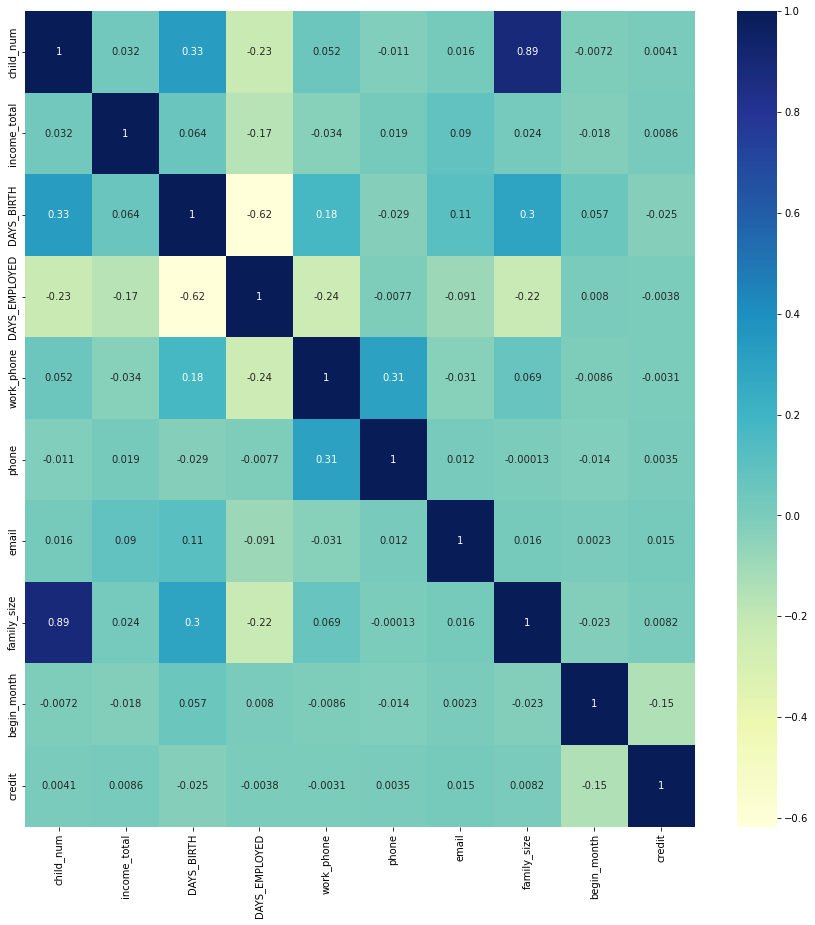

In [222]:
plt.figure(figsize=(15,15))
sns.heatmap(data=train.corr(),annot=True,cmap='YlGnBu')

'child_num'과 'famiiy size','DAYS_BIRTH'와 'DAYS_EMPLOYED' 상관계수가 서로 너무 높으므로 나중에 처리 필요함(다중공산성)

### Data Preprocessing

occyp_type(직업)이 없으면서 DAYS_EMPLOYED(근무시간)이 있는사람(0 이하) 'freelancer'로 대치

In [223]:
train[train['DAYS_EMPLOYED']<0]['occyp_type'].value_counts()

Laborers                 4512
NaN                      3733
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64

In [224]:
test[test['DAYS_EMPLOYED']<0]['occyp_type'].value_counts()

Laborers                 1699
NaN                      1455
Sales staff               946
Core staff                945
Managers                  845
Drivers                   563
High skill tech staff     343
Medicine staff            343
Accountants               339
Cooking staff             198
Security staff            168
Cleaning staff            148
Private service staff     101
Secretaries                54
Waiters/barmen staff       50
Low-skill Laborers         48
HR staff                   23
IT staff                   19
Realty agents              16
Name: occyp_type, dtype: int64

In [225]:
train['occyp_type'] = np.where((train['occyp_type']=='NaN')&(train['DAYS_EMPLOYED']<0),'freelancer',train['occyp_type'])

In [226]:
# train=train[~(train['DAYS_EMPLOYED']=='X')]

In [227]:
test['occyp_type'] = np.where((test['occyp_type']=='NaN')&(test['DAYS_EMPLOYED']<0),'freelancer',test['occyp_type'])

In [228]:
test['occyp_type'].value_counts()

Laborers                 1699
NaN                      1697
freelancer               1455
Sales staff               946
Core staff                945
Managers                  845
Drivers                   563
High skill tech staff     343
Medicine staff            343
Accountants               339
Cooking staff             198
Security staff            168
Cleaning staff            148
Private service staff     101
Secretaries                54
Waiters/barmen staff       50
Low-skill Laborers         48
HR staff                   23
IT staff                   19
Realty agents              16
Name: occyp_type, dtype: int64

In [229]:
# test=test[~(test['DAYS_EMPLOYED']=='X')]

In [230]:
train['family_type'].value_counts()

Married                 18196
Single / not married     3496
Civil marriage           2123
Separated                1539
Widow                    1103
Name: family_type, dtype: int64

Single이면서 아이(child_num)이 있는 데이터 Widow로 대치

In [231]:
train[(train['family_type']=='Single / not married')&(train['child_num']!=0)]

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
126,F,Y,N,1,175500.0,Commercial associate,Secondary / secondary special,Single / not married,Municipal apartment,-11709,-4983,0,0,0,Laborers,2.0,-45.0,2.0
244,M,N,N,1,99000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-17876,-5239,0,0,0,Laborers,2.0,-1.0,1.0
256,F,N,Y,2,360000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-13576,-3560,0,0,0,Sales staff,3.0,-25.0,2.0
443,F,Y,Y,1,315000.0,Working,Incomplete higher,Single / not married,House / apartment,-11725,-2044,0,0,0,Core staff,2.0,-1.0,0.0
452,F,Y,Y,1,180000.0,Working,Higher education,Single / not married,House / apartment,-14226,-3059,0,0,0,Sales staff,2.0,-60.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26246,F,N,N,1,157500.0,Working,Secondary / secondary special,Single / not married,Municipal apartment,-11194,-1160,0,0,0,Cleaning staff,2.0,-34.0,2.0
26297,F,N,Y,1,157500.0,Working,Higher education,Single / not married,With parents,-10304,-433,0,0,0,Secretaries,2.0,-3.0,1.0
26322,F,N,Y,1,135000.0,Working,Secondary / secondary special,Single / not married,Municipal apartment,-16767,-9270,0,0,0,Medicine staff,2.0,-39.0,2.0
26330,F,N,Y,1,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-10968,-1620,0,0,0,freelancer,2.0,-44.0,2.0


In [232]:
train['family_type']=np.where((train['family_type']=='Single / not married')&(train['child_num']!=0),'Widow',train['family_type'])

In [233]:
test[(test['family_type']=='Single / not married')&(test['child_num']!=0)]

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month
38,M,Y,N,1,225000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-13902,-1589,0,1,0,freelancer,2.0,-21.0
65,F,N,Y,2,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-12121,-3718,0,0,0,Core staff,3.0,-7.0
183,M,N,N,1,99000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-17876,-5239,0,0,0,Laborers,2.0,-35.0
236,F,Y,Y,2,180000.0,Working,Higher education,Single / not married,Municipal apartment,-10433,-3019,0,0,0,Laborers,3.0,-23.0
237,M,N,N,1,99000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-17876,-5239,0,0,0,Laborers,2.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9819,F,N,Y,1,135000.0,Working,Secondary / secondary special,Single / not married,Municipal apartment,-16767,-9270,0,0,0,Medicine staff,2.0,-50.0
9896,M,N,N,1,180000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-12947,-137,0,0,0,Laborers,2.0,-48.0
9948,F,N,Y,1,225000.0,State servant,Secondary / secondary special,Single / not married,House / apartment,-15899,-3993,0,0,0,freelancer,2.0,-42.0
9966,F,Y,N,1,135000.0,Commercial associate,Higher education,Single / not married,House / apartment,-10130,-1651,0,0,0,Accountants,2.0,-57.0


In [234]:
test['family_type']=np.where((test['family_type']=='Single / not married')&(test['child_num']!=0),'Widow',test['family_type'])

중복 데이터 삭제

In [235]:
#train[train.duplicated()]

In [236]:
#test[test.duplicated()]

In [237]:
#train.drop_duplicates(inplace=True)

In [238]:
#test.drop_duplicates(inplace=True)

occyp_type(직업)이 없는사람의 근무 시간 0으로 바꿈

In [239]:
train['DAYS_EMPLOYED']=train['DAYS_EMPLOYED'].map(int)

In [240]:
train['DAYS_EMPLOYED']=train['DAYS_EMPLOYED'].apply(lambda x: 0 if x>0 else x)

In [241]:
test['DAYS_EMPLOYED']=test['DAYS_EMPLOYED'].map(int)

In [242]:
test['DAYS_EMPLOYED']=test['DAYS_EMPLOYED'].apply(lambda x: 0 if x>0 else x)

In [243]:
train['DAYS_EMPLOYED'].value_counts()

 0        4438
-401        57
-1539       47
-200        45
-2087       44
          ... 
-10475       1
-2202        1
-2552        1
-680         1
-4973        1
Name: DAYS_EMPLOYED, Length: 3470, dtype: int64

In [244]:
test['DAYS_EMPLOYED'].value_counts()

 0       1697
-1678      22
-1661      21
-401       21
-2057      20
         ... 
-6359       1
-3116       1
-1623       1
-1505       1
-770        1
Name: DAYS_EMPLOYED, Length: 2665, dtype: int64

In [245]:
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,0,0,0,freelancer,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,0,0,0,Core staff,4.0,-2.0,1.0
26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,0,0,0,freelancer,2.0,-47.0,2.0
26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,0,0,0,Core staff,2.0,-25.0,2.0
26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,0,0,0,Laborers,1.0,-59.0,2.0


값이 음수인 'DAYS_BIRTH','DAYS_EMPLOYED','begin_month' 양수로 변경

In [246]:
train.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'occyp_type', 'family_size',
       'begin_month', 'credit'],
      dtype='object')

In [247]:
features = ['DAYS_BIRTH','DAYS_EMPLOYED','begin_month']
for rep in features:
    train[features]=np.abs(train[features])
    test[features]=np.abs(test[features])

In [248]:
train.reset_index(drop=True,inplace=True)

In [249]:
test.reset_index(drop=True,inplace=True)

직업 없는 사람 이름(inoccupation) 변경

In [250]:
train['occyp_type'].value_counts()

Laborers                 4512
NaN                      4438
freelancer               3733
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64

In [251]:
train['occyp_type']=train['occyp_type'].replace('NaN','inoccupation')

In [252]:
test['occyp_type']=test['occyp_type'].replace('NaN','inoccupation')

In [253]:
train['occyp_type'].value_counts()

Laborers                 4512
inoccupation             4438
freelancer               3733
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64

In [254]:
test['occyp_type'].value_counts()

Laborers                 1699
inoccupation             1697
freelancer               1455
Sales staff               946
Core staff                945
Managers                  845
Drivers                   563
High skill tech staff     343
Medicine staff            343
Accountants               339
Cooking staff             198
Security staff            168
Cleaning staff            148
Private service staff     101
Secretaries                54
Waiters/barmen staff       50
Low-skill Laborers         48
HR staff                   23
IT staff                   19
Realty agents              16
Name: occyp_type, dtype: int64

In [255]:
train.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'occyp_type', 'family_size',
       'begin_month', 'credit'],
      dtype='object')

child_num과 family_size 이상치 제거 필요

<AxesSubplot:xlabel='family_size'>

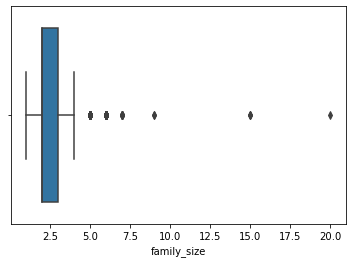

In [256]:
sns.boxplot(train['family_size'])

<AxesSubplot:xlabel='child_num'>

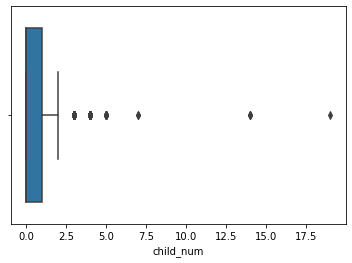

In [257]:
sns.boxplot(train['child_num'])

IQR 이상치(25-75범위만 추출)로 진행

In [258]:
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)

<AxesSubplot:xlabel='family_size'>

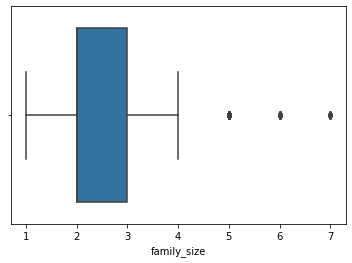

In [259]:
sns.boxplot(test['family_size'])

<AxesSubplot:xlabel='child_num'>

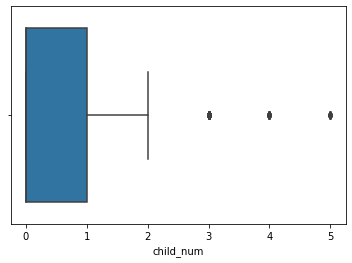

In [260]:
sns.boxplot(test['child_num'])

In [261]:
for df in [train,test]:
    df.reset_index(drop=True,inplace=True)

가족 수가 자식 수보다 적은 데이터 제거

In [279]:
train[(train['family_size'])-(train['child_num'])<=0]

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,before_EMPLOYED,income_total_befofeEMP_ratio,before_EMPLOYED_m,before_EMPLOYED_w,Age,DAYS_BIRTH_m,DAYS_BIRTH_w,EMPLOYED,DAYS_EMPLOYED_m,DAYS_EMPLOYED_w,ability,income_mean,ID
5825,M,Y,Y,1,450000.0,Commercial associate,Secondary / secondary special,Widow,House / apartment,18173,678,0,1,1,Core staff,1.0,16.0,2.0,17495,25.721635,7.0,3.0,49,5.0,0.0,1,10.0,0.0,23.871413,450000.0,1_450000.0_18173_678_0_1_1_1.0_M_Y_Y_Commercia...
16107,F,N,Y,1,108000.0,Working,Secondary / secondary special,Widow,House / apartment,12723,1132,1,1,0,Sales staff,1.0,48.0,2.0,11591,9.317574,2.0,3.0,34,4.0,1.0,3,1.0,1.0,7.795020,108000.0,1_108000.0_12723_1132_1_1_0_1.0_F_N_Y_Working_...
16788,F,N,Y,1,126000.0,Working,Secondary / secondary special,Married,House / apartment,12140,779,0,0,0,Core staff,1.0,37.0,2.0,11361,11.090573,6.0,3.0,33,8.0,2.0,2,1.0,3.0,9.753077,126000.0,1_126000.0_12140_779_0_0_0_1.0_F_N_Y_Working_S...
18876,M,N,Y,1,126000.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,12755,2105,0,0,0,freelancer,1.0,39.0,2.0,10650,11.830986,7.0,1.0,34,5.0,2.0,5,10.0,0.0,8.479139,126000.0,1_126000.0_12755_2105_0_0_0_1.0_M_N_Y_Commerci...
21093,M,N,N,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,16424,1458,0,0,0,Drivers,1.0,25.0,2.0,14966,10.523854,6.0,2.0,44,7.0,2.0,3,0.0,0.0,8.807740,157500.0,1_157500.0_16424_1458_0_0_0_1.0_M_N_N_Working_...


In [269]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000

In [273]:
test[(test['family_size'])-(test['child_num'])<0]

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,before_EMPLOYED,income_total_befofeEMP_ratio,before_EMPLOYED_m,before_EMPLOYED_w,Age,DAYS_BIRTH_m,DAYS_BIRTH_w,EMPLOYED,DAYS_EMPLOYED_m,DAYS_EMPLOYED_w,ability,income_mean,ID


In [274]:
train = train[~((train['family_size'])-(train['child_num'])<0)]

In [275]:
test= test[~((test['family_size'])-(test['child_num'])<0)]

In [276]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26450 entries, 0 to 26450
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        26450 non-null  object 
 1   car                           26450 non-null  object 
 2   reality                       26450 non-null  object 
 3   child_num                     26450 non-null  int64  
 4   income_total                  26450 non-null  float64
 5   income_type                   26450 non-null  object 
 6   edu_type                      26450 non-null  object 
 7   family_type                   26450 non-null  object 
 8   house_type                    26450 non-null  object 
 9   DAYS_BIRTH                    26450 non-null  int64  
 10  DAYS_EMPLOYED                 26450 non-null  int64  
 11  work_phone                    26450 non-null  int64  
 12  phone                         26450 non-null  int64  
 13  e

## Feature engineering

In [277]:
train.to_csv('train4.csv')
test.to_csv('test4.csv')

In [278]:
for df in [train,test]:
    print(df.shape)

(26450, 31)
(9999, 30)


In [ ]:
for

In [267]:
for df in [train,test]:
    # before_EMPLOYED: 고용되기 전까지의 일수
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
    df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)
    
    #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
    df['Age'] = df['DAYS_BIRTH'] // 365
    df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
    df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)

    
    #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))  
    df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
    df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

    #ability: 소득/(살아온 일수+ 근무일수)
    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
    
    #income_mean: 소득/ 가족 수
    df['income_mean'] = df['income_total'] / df['family_size']
    
    #ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)